# Instructions
## Getting the Datasets
* Download the Cohn-Kanade Dataset

## Organize Datasets
* Follow instructions in Face Wizard github repo to organize the datasets

## Setup Google Drive
* Import zipped version of the organized datasets to google drive

## Build Datasets
* Build the dataset according the desired dataset (orginal or cropped)

# Import Dependencies

In [0]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.models import Model
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import History

from google.colab import files
from google.colab import drive

from pathlib import Path
import timeit
import cv2
import os
import shutil
import random
import zipfile

# Mount Google Drive Locally

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Build Dataset

## Build CK Dataset

In [0]:
def build_dataset(data_file):
#   emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happiness":[],
#                  "neutral":[], "no-face":[], "none": [], "sadness":[], "surprise":[], "uncertain":[]}

  emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happy":[],
                 "sadness":[], "surprise":[]}
  zip_file = zipfile.ZipFile(data_file)
  
  for file_name in zip_file.namelist():
    file_name_split = file_name.split('/')
#     print(file_name_split)
    if file_name_split[0] in emotion_hash.keys():
      if "{}/".format(file_name_split[0]) != file_name:
        emotion_hash[file_name_split[0]].append(file_name)
        
  # Check if training_set folder already exists
  # if it already exists, remove all contents and the folder itself
  if os.path.exists("ck_training_set"):
    emotion_list = os.listdir("ck_training_set")
    for emotion in emotion_list:
      sub = os.path.join("ck_training_set", emotion)
      for img in os.listdir(sub):
        os.remove(os.path.join(sub, img))
      os.removedirs(sub)
    
      
  if os.path.exists("ck_testing_set"):
    emotion_list = os.listdir("ck_testing_set")
    for emotion in emotion_list:
      sub = os.path.join("ck_testing_set", emotion)
      for img in os.listdir(sub):
        os.remove(os.path.join(sub, img))
      os.removedirs(sub)
      
  # Create training and testing directories
  os.mkdir("ck_training_set")
  os.mkdir("ck_testing_set")
  
  # Shuffle files and create training and testing sets
  for emotion in emotion_hash.keys():
    training_size = int(.8*len(emotion_hash[emotion]))
    random.shuffle(emotion_hash[emotion])
    i = 0
    while i < training_size:
      zip_file.extract(emotion_hash[emotion][i], "ck_training_set")
      i += 1
    while i < len(emotion_hash[emotion]):
      zip_file.extract(emotion_hash[emotion][i], "ck_testing_set")
      i += 1
    
    

In [0]:
build_dataset("/content/gdrive/My Drive/ck_dataset.zip")

## Build CK Cropped Dataset

In [0]:
def build_dataset(data_file):
#   emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happiness":[],
#                  "neutral":[], "no-face":[], "none": [], "sadness":[], "surprise":[], "uncertain":[]}

  emotion_hash = {"anger":[], "contempt":[], "disgust":[], "fear":[], "happy":[],
                 "sadness":[], "surprise":[]}
  zip_file = zipfile.ZipFile(data_file)
  
  for file_name in zip_file.namelist():
    file_name_split = file_name.split('/')
   # print(file_name_split)
    if file_name_split[0] in emotion_hash.keys():
      if "{}/".format(file_name_split[0]) != file_name:
        emotion_hash[file_name_split[0]].append(file_name)
        
  # Check if training_set folder already exists
  # if it already exists, remove all contents and the folder itself
  if os.path.exists("/content/ck_crop_training_set"):
    emotion_list = os.listdir("/content/ck_crop_training_set")
    for emotion in emotion_list:
      sub = os.path.join("/content/ck_crop_training_set", emotion)
      for img in os.listdir(sub):
        os.remove(os.path.join(sub, img))
      os.removedirs(sub)
    
      
  if os.path.exists("/content/ck_crop_testing_set"):
    emotion_list = os.listdir("/content/ck_crop_testing_set")
    for emotion in emotion_list:
      sub = os.path.join("/content/ck_crop_testing_set", emotion)
      for img in os.listdir(sub):
        os.remove(os.path.join(sub, img))
      os.removedirs(sub)
      
  # Create training and testing directories
  os.mkdir("ck_crop_training_set")
  os.mkdir("ck_crop_testing_set")
  
  # Shuffle files and create training and testing sets
  for emotion in emotion_hash.keys():
    training_size = int(.8*len(emotion_hash[emotion]))
    random.shuffle(emotion_hash[emotion])
    i = 0
    while i < training_size:
      zip_file.extract(emotion_hash[emotion][i], "/content/ck_crop_training_set")
      i += 1
    while i < len(emotion_hash[emotion]):
      zip_file.extract(emotion_hash[emotion][i], "/content/ck_crop_testing_set")
      i += 1

In [0]:
build_dataset("/content/gdrive/My Drive/ck_dataset_cropped.zip")

# Crop Images

# Build Model

## Define Model

In [0]:
def build_model(width, height, depth, classes, finalAct="softmax"):
  # Define pre-trained vgg16 model
  vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(width,height,depth))
    
  model = Sequential()
  for layer in vgg16.layers:
    model.add(layer)
    
  for layer in model.layers:
    layer.trainable = False
    
#   model.add(Conv2D(1024, (3, 3), padding="same"))
#   model.add(Activation("relu"))
#   model.add(BatchNormalization())
#   model.add(Conv2D(1024, (3,3 ), padding="same"))
#   model.add(Activation("relu"))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.25))
  
#   model.add(Conv2D(2048, (3, 3), padding="same"))
#   model.add(Activation("relu"))
#   model.add(BatchNormalization())
#   model.add(Conv2D(2048, (3,3 ), padding="same"))
#   model.add(Activation("relu"))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.25))
    
  model.add(Flatten())
  model.add(Dense(32))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(classes, activation='softmax'))
  
  print("model Summary:")
  model.summary()
    
  opt = Adam(lr=0.001)
    
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model



## Initiate Model

### CK Model

In [0]:
width = 256
height = 256
depth = 3
classes = 7

model = build_model(width, height, depth, classes)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_______

### CK Cropped Model

In [0]:
width = 256
height = 256
depth = 3
classes = 7

model_crop = build_model(width, height, depth, classes)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_______

# Define Data Augmentors

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest')

valid_aug = ImageDataGenerator(rescale=1./255)

# Define Data Batches

## CK Data Batches

In [0]:
train_batch = 65 # 44 steps_per_epoch
valid_batch = 67 # 20 validation_steps


training_path = "ck_training_set"
testing_path = "ck_testing_set"

train_batches = train_aug.flow_from_directory("ck_training_set",
                                             target_size=(width,height),
                                             batch_size=train_batch,
                                             class_mode='categorical')

valid_batches = valid_aug.flow_from_directory("ck_testing_set",
                                             target_size=(width,height),
                                             batch_size=valid_batch,
                                             class_mode='categorical')




## CK Cropped Data Batches

In [0]:
train_batch = 65 # 44 steps_per_epoch
valid_batch = 67 # 20 validation_steps


training_path = "ck_crop_training_set"
testing_path = "ck_crop_testing_set"

train_batches = train_aug.flow_from_directory("ck_crop_training_set",
                                             target_size=(width,height),
                                             batch_size=train_batch,
                                             class_mode='categorical')

valid_batches = valid_aug.flow_from_directory("ck_crop_testing_set",
                                             target_size=(width,height),
                                             batch_size=valid_batch,
                                             class_mode='categorical')




Found 260 images belonging to 7 classes.
Found 67 images belonging to 7 classes.


# Train Model

## Train CK Model

In [0]:
history = History()

model.fit_generator(train_batches,
                   steps_per_epoch=train_batches.samples//train_batches.batch_size,
                   epochs=10,
                   validation_data=valid_batches,
                   validation_steps=valid_batches.samples//valid_batches.batch_size,
                   verbose=1,
                   callbacks=[history])

## Train CK Cropped Model

In [0]:
history_crop = History()

model_crop.fit_generator(train_batches,
                   steps_per_epoch=train_batches.samples//train_batches.batch_size,
                   epochs=1,
                   validation_data=valid_batches,
                   validation_steps=valid_batches.samples//valid_batches.batch_size,
                   verbose=1,
                   callbacks=[history_crop])

Epoch 1/1
4/4 [==============================] - 9s 2s/step - loss: 0.6474 - acc: 0.7923 - val_loss: 0.4558 - val_acc: 0.8358


# Plot Learning Metrics

## Plot CK Metrics

In [0]:
num_epocs = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history.history["loss"], label="train_loss")
plt.plot(range(0, num_epocs), history.history["val_loss"], label="valid_loss")
plt.plot(range(0, num_epocs), history.history["acc"], label="train_acc")
plt.plot(range(0, num_epocs), history.history["val_acc"], label="valid_acc")
plt.title("Emotion Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

## Plot CK Cropped Metrics

### Plot Accuracy

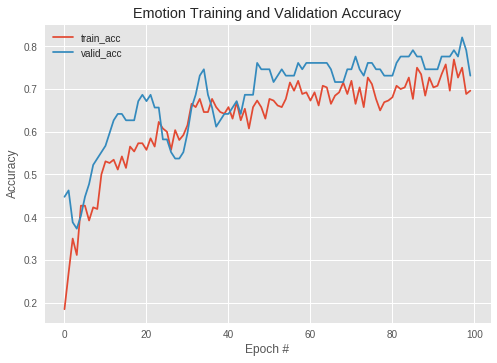

In [0]:
num_epocs = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history_crop.history["acc"], label="train_acc")
plt.plot(range(0, num_epocs), history_crop.history["val_acc"], label="valid_acc")
plt.title("Emotion Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

### Plot Loss

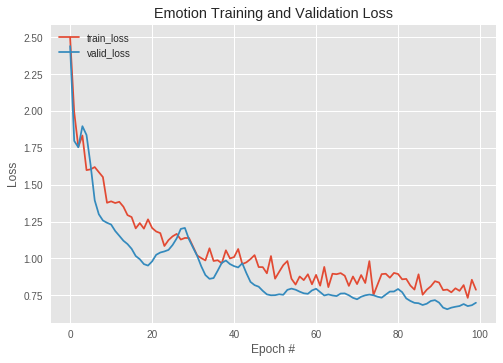

In [0]:
num_epocs = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history_crop.history["loss"], label="train_loss")
plt.plot(range(0, num_epocs), history_crop.history["val_loss"], label="valid_loss")
plt.title("Emotion Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

### Plot Loss and Accuracy 

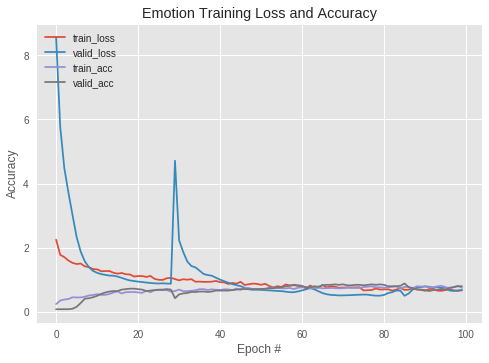

In [0]:
  num_epocs = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, num_epocs), history_crop.history["loss"], label="train_loss")
plt.plot(range(0, num_epocs), history_crop.history["val_loss"], label="valid_loss")
plt.plot(range(0, num_epocs), history_crop.history["acc"], label="train_acc")
plt.plot(range(0, num_epocs), history_crop.history["val_acc"], label="valid_acc")
plt.title("Emotion Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

# Predict Emotions

## Crop Face

In [0]:
def crop_face(path_to_image):
  face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/haarcascade_frontalface_default.xml')
  img = cv2.imread(path_to_image)
  plt.imshow(img)
  img = cv2.resize(img, (256,256))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  face = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in face:
#     cv2.rectangle(img, (x,y), (x+w,  y+h), (255,0,0), 2)
    img = img[y:y+h, x:x+w] # This line crops the face from image
#     region_of_interest_gray = gray[y:y+h, x:x+w]
#     region_of_interest_color = gray[y:y+h, x:x+w]
  
#   plt.imshow(img)
#   cv2.imwrite(path_to_image, img)
  return img

## Prepare Image for Prediction

In [0]:
def prep_img(img):
#   img = cv2.imread(img_path)
  img = cv2.resize(img, (256,256))
#   cv2.imwrite(img_path, img)
  img = img.astype("float")/ 255.0
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)


#   image = cv2.imread(img_path)
#   plt.imshow(image)
  
  return img

## Predict Image

In [0]:
def predict_emotion(model, img_path):
  emotion_labels = {0:"anger", 1:"contempt", 2:"disgust", 3:"fear", 4:"happy", 5:"sadness", 6:"surprise"}

  img = crop_face(img_path)

  # img_view = cv2.imread(img_path)
  # plt.imshow(img_view)
  img = prep_img(img)

  prediction = model.predict(img)
  print("All Predictions", prediction)

  pred = prediction.argmax(axis=1)[0]
  print("Max Prediction: ", pred)

  predicted_emotion = None
  if pred in emotion_labels.keys():
    predicted_emotion = emotion_labels[pred]

  print("Predicted Emotion is:", predicted_emotion)
  print("Confidence:", prediction[0][pred])

All Predictions [[0.7083208  0.03839724 0.03232687 0.06197805 0.02965983 0.08218256
  0.04713455]]
Max Prediction:  0
Predicted Emotion is: anger
Confidence: 0.7083208


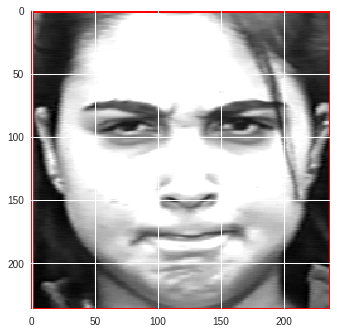

In [0]:
test_path = "ck_crop_testing_set/anger"
testing_imgs = os.listdir(test_path)
img_path = os.path.join(test_path, testing_imgs[0])

# img = crop_face(img_path)
# img = prep_img(img)

predict_emotion(model_crop, img_path)

# Plot Feature Maps

In [0]:
def plot_feature_maps(feature_maps):
  height, width, depth = feature_maps.shape
  nb_plot = int(np.rint(np.sqrt(depth)))
  fig = plt.figure(figsize=(30,30))
  for i in range(depth):
    plt.subplot(nb_plot, nb_plot, i+1)
    plt.imshow(feature_maps[:,:,i], cmap='gray')
    plt.title('feature map {}'.format(i+1))
  plt.show()

In [0]:
def plot_layer(model, layer_name, img_path):
  img = crop_face(img_path)
  img = prep_img(img)
  model_crop_layers = [layer.name for layer in model.layers]
  assert layer_name in model_crop_layers
  print(model.input)
  feature_ext = Model(inputs=model.input, outputs=model.get_layer(layer_name).get_output_at(0))
  feature_maps = feature_ext.predict(img)[0]
  print("At layer \"{}\" : {}".format(layer_name, feature_maps.shape))
  plot_feature_maps(feature_maps)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
At layer "block1_conv2" : (256, 256, 64)


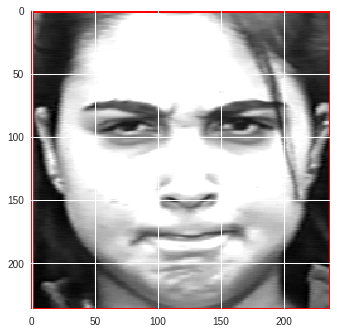

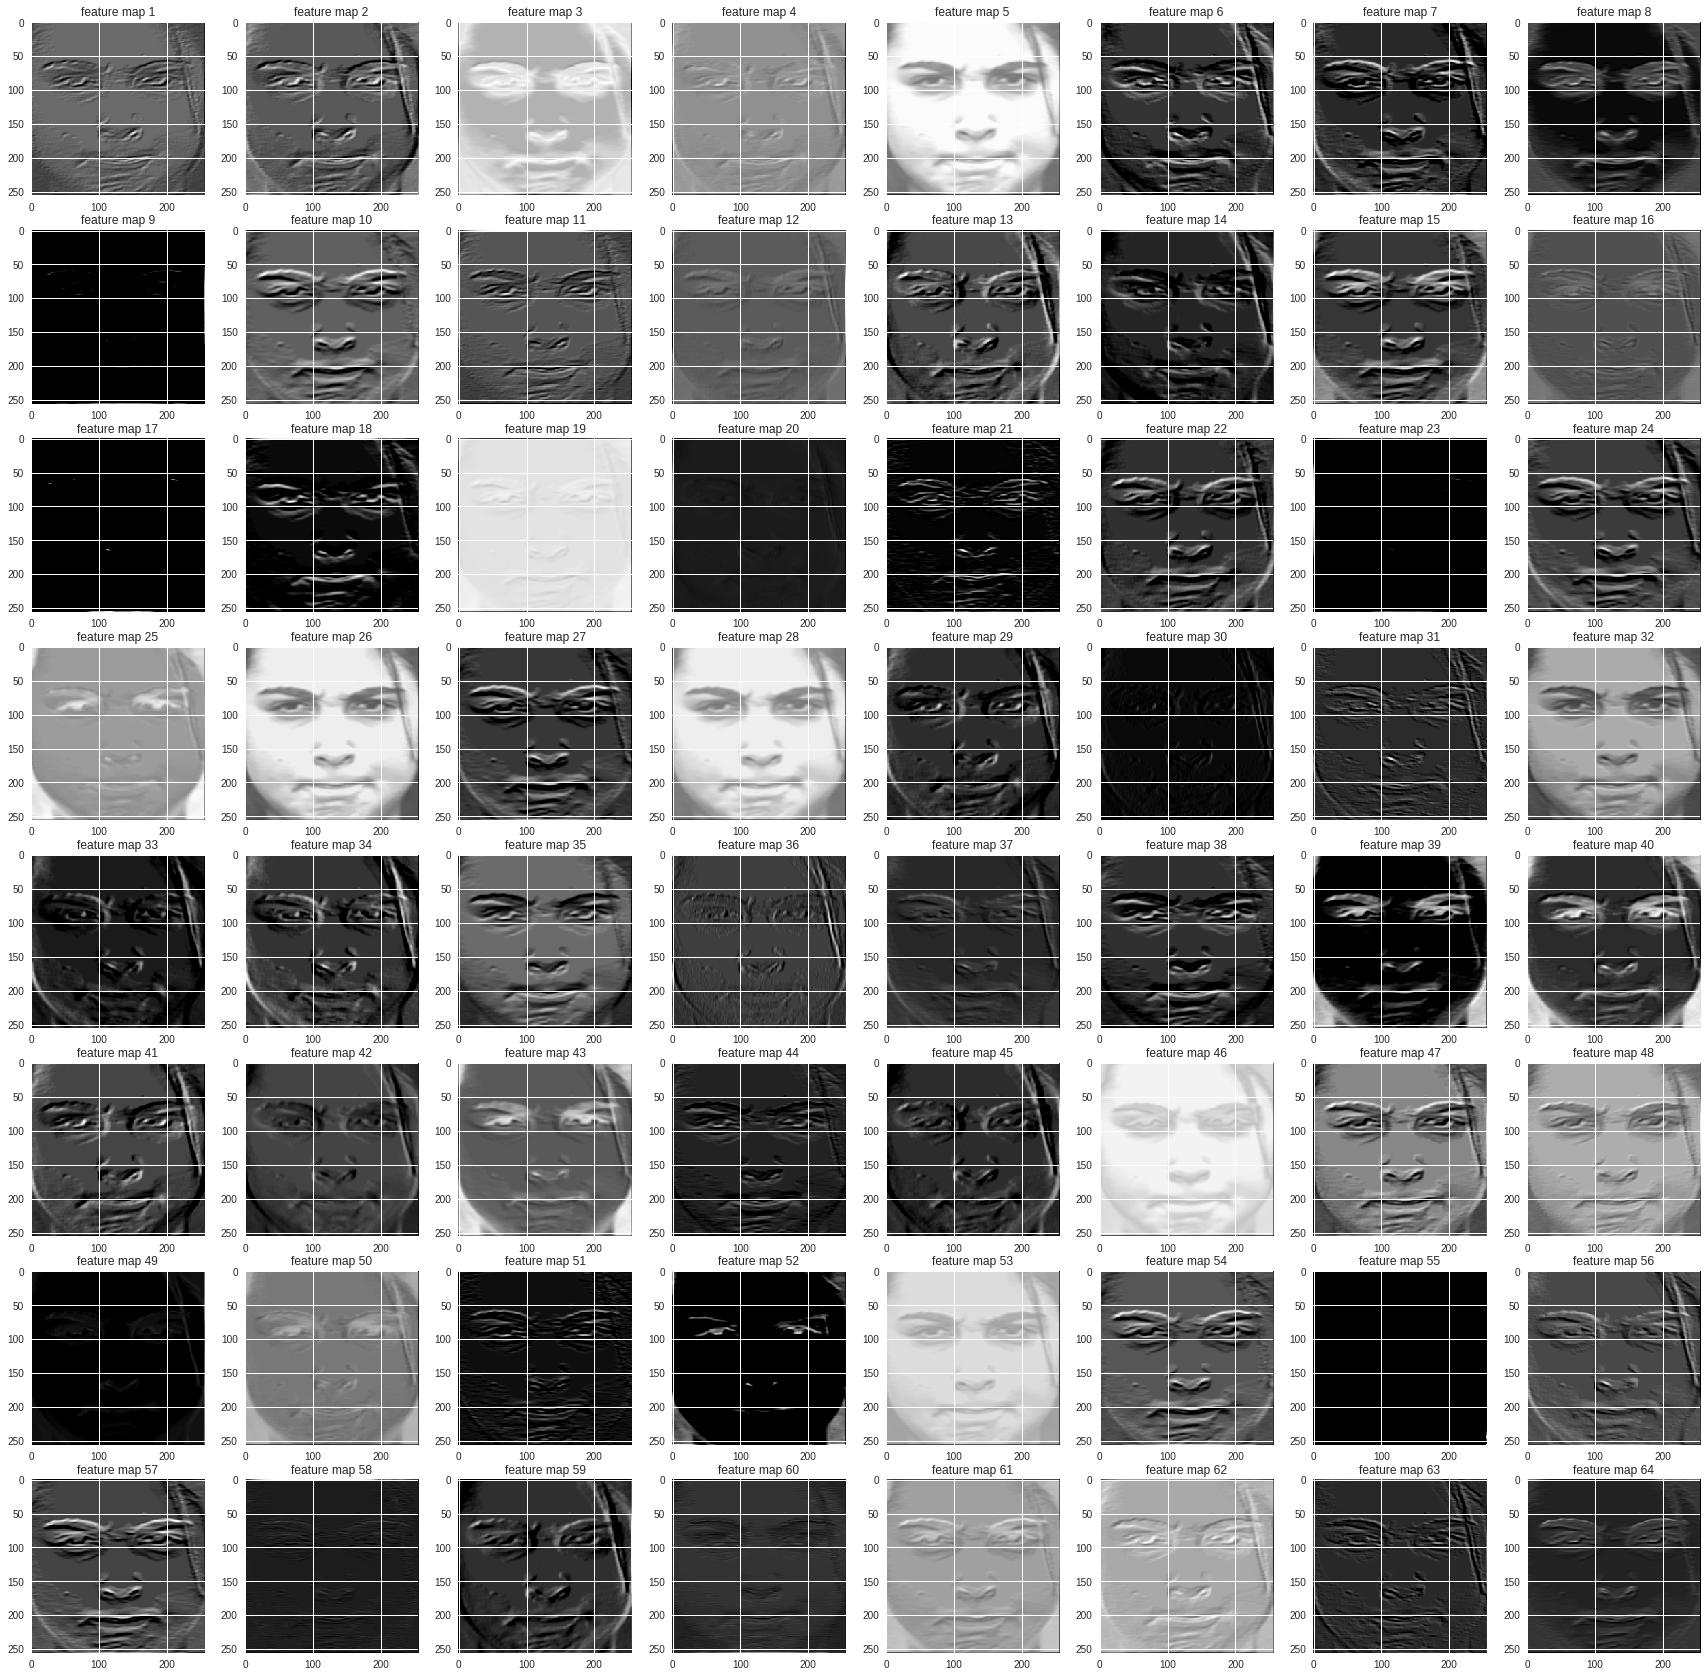

In [0]:
test_path = "ck_crop_testing_set/anger"
testing_imgs = os.listdir(test_path)
img_path = os.path.join(test_path, testing_imgs[0])

plot_layer(model_crop, 'block1_conv2', img_path)